In [1]:
import numpy as np
from scipy import linalg
from scipy.integrate import solve_bvp
from scipy.optimize import curve_fit, root, fsolve, minimize_scalar

from scipy.interpolate import interp1d

from scipy.special import zeta

from joblib import Parallel, delayed

from tqdm import tqdm
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",            # Use serif font family (default in LaTeX)
    "font.serif": ["Computer Modern"],
    "font.size": 27,
    "text.latex.preamble": r"\usepackage{color}",
})
plt.rcParams["figure.figsize"] = (7, 7)

In [3]:
# T_{c0} = 3.8\ K,\qquad \xi = 10\times 10^{-9}\ m\to 	
# \mathcal{A}_H = \frac{g\mu_B H_{c2}}{\pi T_{c0}} \to 
# \frac{ 1 \times  \times  \frac{\times}{2\times  \times ()^2}}{3.14 \times 3.8\ K \times} = 
#

gLande = 2.
muB = 9.3*1e-21 # \frac{erg}{G}
hbar = 1e-27 # erg\times s
c = 3e10 # cm/s
e0 = 4.8*1e-10 # statC
xi0 = 100*1e-10*1e2 # cm
Tc0 = 3.8 # K
kB =  1.4e-16 # \frac{erg}{K}
Hc2 = hbar*c/(2.*e0*xi0**2)
print(" Hc2 = ", Hc2, "G = ", Hc2/1e4, "T")
A_H = np.float64(gLande * muB * Hc2 / (np.pi * kB * Tc0))
print(" A_H = ", A_H)

sigmaD = 9e15 # s^{-1}
j_s0 = sigmaD * 3.14 * kB * Tc0 / (e0 * xi0)
print(" j_s0 = ", j_s0,"statC/s = ", j_s0*1e4/(3e9),"A/m^2")

mathcalB = c * Hc2 / (4 * 3.14 * j_s0 * xi0)
print(" mathcalB = ", mathcalB)

 Hc2 =  31250.0 G =  3.125 T
 A_H =  0.3477774837299405
 j_s0 =  3.13215e+16 statC/s =  104405000000.00002 A/m^2
 mathcalB =  2383.0825389979063


In [5]:
# T_{c0} = 3.8\ K,\qquad \xi = 10\times 10^{-9}\ m\to 	
# \mathcal{A}_H = \frac{g\mu_B H_{c2}}{\pi T_{c0}} \to 
# \frac{ 1 \times  \times  \frac{\times}{2\times  \times ()^2}}{3.14 \times 3.8\ K \times} = 
#

gLande = 2.
muB = 9.3*1e-21 # \frac{erg}{G}
hbar = 1e-27 # erg\times s
c = 3e10 # cm/s
e0 = 4.8*1e-10 # statC
xi0 = 100*1e-10*1e2 # cm
Tc0 = 3.8 # K
kB =  1.4e-16 # \frac{erg}{K}
Hc2 = hbar*c/(2.*e0*xi0**2)
print(" Hc2 = ", Hc2, "G = ", Hc2/1e4, "T")
A_H = np.float64(gLande * muB * Hc2 / (np.pi * kB * Tc0))
print(" A_H = ", A_H)

sigmaD = 9e15 # s^{-1}
j_s0 = sigmaD * 3.14 * kB * Tc0 / (e0 * xi0)
print(" j_s0 = ", j_s0,"statC/s = ", j_s0*1e4/(3e9),"A/m^2")

mathcalB = c * Hc2 / (4 * 3.14 * j_s0 * xi0)
print(" mathcalB = ", mathcalB)

 Hc2 =  31250.0 G =  3.125 T
 A_H =  0.3477774837299405
 j_s0 =  3.13215e+16 statC/s =  104405000000.00002 A/m^2
 mathcalB =  2383.0825389979063


In [7]:
def _gauss_series_weights(n):
    r"""
    Compute Gauss quadrature weights for an infinite series.

    .. math::

       \sum_{j=1}^\infty f(j) \simeq \sum_{k=1}^n w_k f(x_k)

    Uses the method in [1]_.

    Parameters
    ----------
    n : int
        Number of quadrature points to return.

    Returns
    -------

    References
    ----------
    .. [1] H. Monien, "Gaussian quadrature for sums: a rapidly
       convergent summation scheme", Math. Comp. 79, 857 (2010).
       doi:10.1090/S0025-5718-09-02289-3

    """
    if n <= 0:
        raise ValueError("n must be positive")
    elif n == 1:
        return np.array([1.0]), np.array([1.0])

    j = np.arange(n)
    j1 = j[1:]

    # Method in [1]: gauss quadrature weights for
    #
    #    sum_{k=1}^oo 1/k^2 f(1/k^2)
    #
    # The abscissas are zeros of `p_n(lmb)` where:
    #
    # lmb = 1/x**2
    # p_n = lambda n, lmb: bessel_poly_yn(2*n+1, -1j*np.sqrt(lmb)/np.pi).real
    # bessel_poly_yn = lambda n, x: np.sqrt(2/(np.pi*x)) * np.exp(1/x) * special.kv(n+0.5, 1/x)

    # Recurrence formula from [1]
    a = 2 * np.pi**2 / (4 * j + 1) / (4 * j + 5)
    a[0] = np.pi**2 / 15
    sqrt_b = np.pi**2 / np.sqrt((4 * j1 - 1) * (4 * j1 + 3)) / (4 * j1 + 1)

    m0 = np.pi**2 / 6  # = sum_{k=1}^oo 1/k^2

    # Compute eigenvalues and first elements of eigenvectors
    #
    # What follows is equivalent to::
    #
    #     z, w = linalg.eigh_tridiagonal(a, sqrt_b)
    #     w = w[0,:]
    #
    # but uses less memory (we only need the first element of each
    # eigenvector).

    m, z, iblock, isplit, info = linalg.lapack.dstebz(a, sqrt_b, 0, 0, 0, 0, 0, 0, "B")
    if info != 0:
        raise ValueError("dstebz failed")

    block_size = max(10, 6250000 // n)

    w = np.empty_like(z)
    iblock2 = np.empty(n, dtype=int)
    for k in range(0, n, block_size):
        zb = z[k : k + block_size]
        iblock2[: len(zb)] = iblock[k : k + block_size]
        wb, info = linalg.lapack.dstein(a, sqrt_b, zb, iblock2, isplit)
        if info != 0:
            raise ValueError("dstein failed at k={}".format(k))
        w[k : k + block_size] = wb[0, :]

    # Then find eigenvectors, one by one

    # Convert back to unweighted sum (z = 1/x^2)
    w = m0 * w**2 / z
    x = z ** (-0.5)

    # Swap order
    x = x[::-1]
    w = w[::-1]

    x.flags.writeable = False
    w.flags.writeable = False

    return x, w

def get_matsubara_sum(T, E_typical=1.0, max_ne=2000, steps=1):
    r"""
    Get Matsubara sum/quadrature.

    Gives the approximation:

    .. math::

       T \sum_{n=-\infty}^\infty f(\omega_n) \simeq \sum_{j=0}^{M-1} a_j f(w_j)

    where :math:`f(\omega)` is an analytic function decaying sufficiently
    fast at :math:`\omega\to\pm\infty`.

    The quadrature applies the method of [1]_, which is based on applying
    the idea of Gaussian quadrature to infinite summation of polynomials
    in :math:`z = n^{-2}`.

    Parameters
    ----------
    T : float
        Temperature
    E_typical : float
        Expected typical energy scale of the summand
    max_ne : int
        Max number of frequencies in summation

    Returns
    -------
    w : ndarray
        Energies to evaluate at
    a : ndarray
        Quadrature weights

    Examples
    --------
    >>> import numpy as np
    >>> from usadelndsoc.matsubara import get_matsubara_sum
    >>> w, a = get_matsubara_sum(T=1, E_typical=1)
    >>> n = w / (2*np.pi) + 0.5; n
    array([-55.01190294, -17.89542335, -10.6225115 ,  -7.63686822,
            -6.07573899,  -5.00201745,  -4.00000629,  -3.        ,
            -2.        ,  -1.        ,   0.        ,   1.        ,
             2.        ,   3.        ,   4.        ,   5.00000629,
             6.00201745,   7.07573899,   8.63686822,  11.6225115 ,
            18.89542335,  56.01190294])
    >>> (a * 1/w**2).sum(), 1/4
    (0.25000271006449587, 0.25)

    The above Gaussian quadrature based sum converges much faster
    than the naive one:

    >>> w_naive = 2*np.pi*(np.arange(-60, 60) + 0.5)
    >>> (1/w_naive**2).sum()
    0.24915567634606217

    The quadrature is exact for :math:`\sum_{n=1}^\infty p(n^{-2})`
    where `p` is a polynomial up to high order:

    >>> a = a[n>0]; n = n[n>0]
    >>> (a * (1/n**2 + 2/n**4 + 4/n**16)).sum()
    7.809641663308138
    >>> import sympy; m = sympy.symbols('m')
    >>> r = sympy.Sum(1/m**2 + 2/m**4 + 4/m**16, (m, 1, sympy.oo)).doit()
    >>> r
    pi**2/6 + pi**4/45 + 7234*pi**16/162820783125
    >>> r.n()
    7.80964166330814

    References
    ----------
    .. [1] H. Monien, "Gaussian quadrature for sums: a rapidly
       convergent summation scheme", Math. Comp. 79, 857 (2010).
       doi:10.1090/S0025-5718-09-02289-3

    """

    E_max = 1000 * abs(E_typical)
    try:
        ne = 5 + int(np.sqrt(4 * E_max / (np.pi**2 * abs(T))))
        k, rem = divmod(ne, steps)
        if rem != 0:
            k += 1
        ne = k * steps
    except (ZeroDivisionError, OverflowError):
        ne = np.inf

    if not (ne < max_ne):
        raise ValueError("Too many matsubara frequencies required")

    # Get weights for sum_{n=1}^oo f(n) =~ sum(weights * f(x))
    x, weights = _gauss_series_weights(ne)

    E = 2 * np.pi * T * (x - 0.5)
    #weights = weights * T

    assert E[-1] >= E_max

    # Get two-tailed
    E = np.r_[-E[::-1], E]
    weights = np.r_[weights[::-1], weights]

    k = int(E.size/2)
    return E[k:], weights[k:]

In [9]:
class S_I_bilayer:

    def Get_Delta_s_In_pi_Tc(self, t):
        result_prev = 0.
        result = 2.
        if (t > 1.0):
            return 0.
        while (np.abs(result - result_prev) >= self.eps_t):
            result_prev = result
            S_prev = 0
            S = 0
            S1_prev = 0
            S1 = 0
            i = 0
            # all the sums over \omega_n here are convergent
            # thus, we evaluate them until the precision eps_t/1e3 is reached
            while True:
                S_prev = S
                S1_prev = S1
                S = S + 1./(2*i+1) - t/np.sqrt(result**2 + t**2*(2*i+1)**2)
                S1 = S1 + 1./np.power(result**2 + t**2*(2*i+1)**2, 1.5)
                i = i + 1
                if  np.sqrt((S - S_prev)**2 + (S1 - S1_prev)**2) <= self.eps_t/1e3:
                    break
                p = (2*S + np.log(t))/(2*S + np.log(t) + t*result**2**2*S1)
            result = result* 2*S1*t*result**2/(2*S + np.log(t) + 2*S1*t*result**2)  
        return result # it returtns Delta_s/(\pi T_c0)

    def Get_tildeW(self, t):
        Delta = self.Get_Delta_s_In_pi_Tc(t)
        return (0.5*np.pi*Delta)*np.tanh(np.pi*Delta/(2*t))

    def H_z(self, z, p):
        # p = [d_S, theta_I, H0, n_Matsubara, t, Delta, p_S0, tildeGamma]
        # p_S0 = (tildeI - tildeJ)/(d_S*tildeW)
        H0 = p[2]
        return H0
    
    def P_S_z(self, z, p):
        # p = [d_S, theta_I, H0, n_Matsubara, t, Delta, p_S0, tildeGamma]
        # p_S0 = (tildeI - tildeJ)/(d_S*tildeW)
        d_S = p[0]
        H0 = p[2]
        p_S0 = p[6]
        return - H0*(z - d_S/2.) + p_S0
            

    def theta_zeta_solutions(self, p):
        # Y = [theta_re, theta_im, theta'_re, theta'_im, zeta_re, zeta_im, zeta'_re, zeta'_im]
        # p = [d_S, theta_I, H0, n_Matsubara, t, Delta, p_S0, tildeGamma]
        # p_S0 = (tildeI - tildeJ)/(d_S*tildeW)
        H0 = p[2]
        n_Matsubara = p[3]
        t = p[4]
        omega_n = t*(2. * n_Matsubara + 1.)
        Delta = p[5]
        p_S0 = p[6]
        def Foo(d_S, theta_I, tildeGamma, p_S, H0, omega_n, Delta, X):
            # X = [theta_re, theta_im, zeta_re, zeta_im]
            theta = X[0] + 1j*X[1]
            zeta = X[2] + 1j*X[3]
            X = p_S**2 + d_S**2*H0**2/12
            p_S1 = H0*d_S/2 + p_S
            I1 = 1j*theta_I*p_S1*np.sinh(zeta)*np.cosh(zeta)**2*np.cosh(theta)/d_S -0.5*X*np.cosh(2*zeta)*np.sinh(2*theta) - \
                        omega_n*np.cosh(zeta)*np.sinh(theta) - 1j*np.cosh(theta)*(Delta*np.cosh(zeta) + A_H*H0*np.sinh(zeta))
            I2 = 1j*theta_I*p_S1*(np.cosh(zeta) + 3*np.cosh(3*zeta))*np.sinh(theta)/(4*d_S) - 2*tildeGamma*np.sinh(2*zeta)/d_S  - \
                        0.5*X*np.sinh(2*zeta)*np.cosh(2*theta) - \
                        omega_n*np.sinh(zeta)*np.cosh(theta) - 1j*np.sinh(theta)*(Delta*np.sinh(zeta) + A_H*H0*np.cosh(zeta))
            return np.array([np.real(I1), np.imag(I1), np.real(I2), np.imag(I2)])

        theta0 = np.arctanh(-1j*Delta/omega_n)
        zeta0 = 0
        d_S = p[0]
        theta_I = p[1]
        tildeGamma = p[7]
        R = root(lambda X: Foo(d_S, theta_I, tildeGamma, p_S0, H0, omega_n, Delta, X), 
                 np.array([np.real(theta0), np.imag(theta0), np.real(zeta0), np.imag(zeta0)]), method="krylov", tol=self.eps_t).x
        theta0 = R[0] + 1j*R[1]
        zeta0 = R[2] + 1j*R[3]

        norm = np.linalg.norm(Foo(d_S, theta_I, tildeGamma, p_S0, H0, omega_n, Delta, 
                    np.array([np.real(theta0), np.imag(theta0), np.real(zeta0), np.imag(zeta0)])))

        if (norm >= self.eps_t):
            print("-----> ! theta_0 = ", theta0, 
                  " zeta0 = ", zeta0, 
                  " |Foo(theta0, zeta0)| = ", norm)
        
        return theta0, zeta0

    def Solve_Usadel_at_omega_n(self, p):
        # Y = [theta_re, theta_im, theta'_re, theta'_im, zeta_re, zeta_im, zeta'_re, zeta'_im]
        # p = [d_S, theta_I, H0, n_Matsubara, t, Delta, p_S0, tildeGamma]
        # p_S0 = (tildeI - tildeJ)/(d_S*tildeW)
        theta_I = p[1]
        n_Matsubara = p[3]
        t = p[4]
        Delta = p[5]
        theta0, zeta0 = self.theta_zeta_solutions(p)    
        theta = theta0
        zeta = zeta0
        theta1 = theta0
        zeta1 = zeta0 
        fs_averaged = np.cosh(zeta)*np.sinh(theta) 


        omega_n = t*(2*n_Matsubara + 1)
        Q = p[6] 
        H0 = p[2]
        d_S = p[0]
        t = p[4]
        #X = Q**2 + H0**2*d_S**2/12/t
        #fs_theor = - 1j*Delta*(omega_n  + X)/( (omega_n + X)**2 + ((A_H - c.theta_I/2)*H0 - c.theta_I*Q/c.d_S)**2 )
        #print(" fs_averaged = ", fs_averaged, " fs_theor = ", fs_theor)
        #print("  ", np.abs(fs_averaged - fs_theor)/np.abs(fs_averaged))
        
        delta_Delta = 2*(Delta/(2*n_Matsubara + 1) + t*np.imag(fs_averaged))
        #delta_tildeW = np.real( -t*(np.cosh(2*zeta)*np.cosh(2*theta) - 1)) 
        #delta_tildeJ = -np.imag(- (t*2*theta_I)*np.sinh(zeta1)*np.cosh(zeta1)**2*np.sinh(theta1))
        return  delta_Delta, theta, zeta

    def Sum_for_Delta_W_J(self, X, d_S, theta_I, H0, t, tildeGamma, p_S0): 
        Delta = X[0]
        S = 0.
        W, A = get_matsubara_sum(T=t, E_typical=t)
        W = np.flip(W)
        A = np.flip(A)
        i = 0
        Delta_S = 0.
        while i < len(W):
            w = W[i]
            a = A[i]
            p = [d_S, theta_I, H0,  (w/(np.pi*t) - 1.)/2., t, Delta, p_S0, tildeGamma]
            Delta_S, theta, zeta = self.Solve_Usadel_at_omega_n(p)
            S = S + a*Delta_S          
            S_prev = S
            i = i + 1
        S = S + np.log(t)*Delta
        if np.isclose(S, 0):
            S = 0.
        return S

    def Get_state_root(self, d_S, theta_I, tildeGamma, p_S0, H0, t, Delta0=0., tildeW0=0., tildeJ0=0.):
        # p = [d_S, theta_I, H0, n_Matsubara, t, Delta, p_S0, tildeGamma]
        if np.isclose(Delta0, 0):
            Delta0 = self.Get_Delta_s_In_pi_Tc(t)
            tildeW0 = self.Get_tildeW(t)
            tildeJ0 = 0.
        Foo = lambda X: self.Sum_for_Delta_W_J(X, d_S, theta_I, H0, t, tildeGamma, p_S0) 
        R = root(Foo, [Delta0], method="krylov", tol=self.eps_t).x   
        Delta = R[0]
        if np.linalg.norm(Foo(R)) >= self.eps_t:
            print("---------> Get_state_root problem: Delta = ", Delta, "|S| = ", np.linalg.norm(Foo(R)) )
        W, A = get_matsubara_sum(T=t, E_typical=t)
        W = np.flip(W)
        A = np.flip(A)
        i = 0
        tildeW = 0.
        tildeJ = 0.
        while i < len(W):
            w = W[i]
            a = A[i]
            p = [d_S, theta_I, H0,  (w/(np.pi*t) - 1.)/2., t, Delta, p_S0, tildeGamma]
            Delta_S, theta, zeta = self.Solve_Usadel_at_omega_n(p)
            i = i + 1
            theta1 = theta
            zeta1 = zeta
            tildeW = tildeW + a*np.real(-t*(np.cosh(2*zeta)*np.cosh(2*theta) - 1) )
            tildeJ = tildeJ + a*np.imag(- (t*2*theta_I)*np.sinh(zeta1)*np.cosh(zeta1)**2*np.sinh(theta1))
        return np.array([Delta, tildeW, tildeJ])


    def pS_characteristics(self, H0, t, p_S_step=0.5*1e-3, p_S_min=-0.05, p_S_max=0.05, to_disk=True, verbose=False):
        # p_S0 = (tildeI - tildeJ)/(d_S*tildeW)
        p_S_data = np.array([])
        data_tildeW = np.array([])
        data_Delta = np.array([])
        data_tildeI = np.array([])
        data_tildeJ = np.array([])

        Delta = self.Get_Delta_s_In_pi_Tc(t)
        p_S0 = 0.
        while p_S0 < p_S_max:
            Delta, tildeW, tildeJ = self.Get_state_root(self.d_S, self.theta_I, self.tildeGamma, p_S0, H0, t)
            tildeI = tildeJ + tildeW * self.d_S * p_S0
            if verbose:
                print("""--> : p_S = {:.3e}, Delta = {:.3e}, tildeW = {:.3e}, 
                        tildeJ = {:.3e}, tildeI = {:.3e},""".format(p_S0, Delta, tildeW, tildeJ, tildeI))
            data_tildeW = np.append(data_tildeW, tildeW)
            data_Delta = np.append(data_Delta, Delta)
            data_tildeJ = np.append(data_tildeJ, tildeJ)
            data_tildeI = np.append(data_tildeI, tildeI)
            p_S_data = np.append(p_S_data, p_S0)
            p_S0 = p_S0 + p_S_step
            #if Delta < 1e-4:
            #    break

        Delta = self.Get_Delta_s_In_pi_Tc(t)
        p_S0 = 0.
        while p_S0 > p_S_min:
            Delta, tildeW, tildeJ = self.Get_state_root(self.d_S, self.theta_I, self.tildeGamma, p_S0, H0, t)
            tildeI = tildeJ + tildeW * self.d_S * p_S0
            if verbose:
                print("""--> : p_S = {:.3e}, Delta = {:.3e}, tildeW = {:.3e}, 
                        tildeJ = {:.3e}, tildeI = {:.3e},""".format(p_S0, Delta, tildeW, tildeJ, tildeI))
            data_tildeW = np.append(data_tildeW, tildeW)
            data_Delta = np.append(data_Delta, Delta)
            data_tildeJ = np.append(data_tildeJ, tildeJ)
            data_tildeI = np.append(data_tildeI, tildeI)
            p_S_data = np.append(p_S_data, p_S0)
            p_S0 = p_S0 - p_S_step
            #if Delta < 1e-4:
            #    break

        if not to_disk:
            return [p_S_data, data_Delta, data_tildeI, data_tildeJ, data_tildeW]
                
        fname = "I_S_p_S_d_S={}_theta_I={}_t={}_H0={}".format(round(self.d_S, 5), round(self.theta_I, 5), round(t, 5), round(H0, 5))
        sdata = "# I_S on p_S0 dependence for d_S = {}, theta_I = {} \n".format(self.d_S, self.theta_I)
        sdata = sdata + "# t = {}, H_0 = {} \n".format(t, H0)
        sdata = sdata  + "# p_S tildeI Delta tildeW tildeJ \n"
        fname = fname.replace(".","-")
        fname = fname + ".dat"
        file = open(fname, "w")
        file.write(sdata)
        for i in range(len(p_S_data)):
            file.write("{} {} {} {} {} \n".format(p_S_data[i], data_tildeI[i], data_Delta[i], data_tildeW[i], data_tildeJ[i]))
        file.close()
        
        return [p_S_data, data_Delta, data_tildeI, data_tildeJ, data_tildeW]

    def Get_state_at_fixed_current(self, H0, t, tildeI0=0., p_S_step=0.25*1e-3, p_S_min=-0.05, p_S_max=0.05, verbose=False):
        data = self.pS_characteristics(H0, t, p_S_step=p_S_step, p_S_min=p_S_min, p_S_max=p_S_max)
    
        tildeDeltas = interp1d(data[0], data[1], bounds_error=True, kind='linear')
        tildeIs = interp1d(data[0], data[2], bounds_error=True, kind='linear')
        tildeJs = interp1d(data[0], data[3], bounds_error=True, kind='linear')
        tildeWs = interp1d(data[0], data[4], bounds_error=True, kind='linear')

        if np.isclose(np.min(data[0]), np.max(data[0])):
            return np.array([0, 0, 0])

        k = np.argmin(data[2])
        j = np.argmax(data[2])
        bounds = (np.min([data[0][k], data[0][j]]), np.max([data[0][k], data[0][j]]))
        res = minimize_scalar(lambda x: np.abs(tildeIs(x) - tildeI0),
                         bounds=bounds,
                         method='bounded',
                         options={'xatol': self.eps_t})
        pS_star = res.x
        if (pS_star > bounds[1] or pS_star < bounds[0]):
            print("""---> Resulting pS_star is out of bounds: 
            p_S_star = {}, H0 = {}, t = {}, tildeI0 = {} \n""".format(pS_star, H0, t, tildeI0))
        
        Delta, tildeW, tildeJ = tildeDeltas(pS_star), tildeWs(pS_star), tildeJs(pS_star)
        if verbose:
            print("---> pS_star = {}, Delta = {}, tildeW = {}, tildeJ = {} \n".format(pS_star, Delta, tildeW, tildeJ))

        if np.abs(tildeIs(pS_star) - tildeI0) >= self.eps_t:
            print("---> Could not find pS_star: H0 = {}, t = {}, tildeI0 = {} \n".format(H0, t, tildeI0))

        return Delta, tildeW, tildeJ
        
    
    def __init__(self, d_S, theta_I, tildeGamma=0.):
        self.eps_t = 1e-7# precision for Delta, \tilde{Q}, \tilde{J}, etc...
        self.d_S = d_S
        self.theta_I = theta_I
        self.tildeGamma = tildeGamma

    def Tc_theory(self, d_S, theta_I, tildeGamma, H0):
        k1 = 1. - np.pi**4*tildeGamma/(21*zeta(3)*d_S)
        k2 = - np.pi**4*tildeGamma*theta_I**2/(3*d_S**3)
        pS_0m = 7*zeta(3)*theta_I*(A_H - theta_I/2)*k1*H0/(d_S*(np.pi**2 + 7*zeta(3)*theta_I**2/d_S**2 + k2))
        p = (A_H*H0 - theta_I*H0/2 - theta_I*pS_0m/d_S)
        X = pS_0m**2 + H0**2*d_S**2/12
        tc0 = 1 - np.pi**2*X/4  - 7*zeta(3)*p**2/4 + tildeGamma*np.pi**4*p**2/12/d_S 
        return tc0, pS_0m

    def Tc_theory_full_p_Sa(self, d_S, theta_I, tildeGamma, H0):
        def foo(t, d_S, theta_I, tildeGamma, H0, p_S):
            X = p_S**2/t + d_S**2*H0**2/12/t
            W, A = get_matsubara_sum(T=t, E_typical=t)
            S = 0.
            for i in range(len(W)):
                w = W[i]
                a = A[i]
                n_Matsubara = (w/(np.pi*t) - 1.)/2.
                y = (2*n_Matsubara + 1)
                omega_n = y*t
                C = omega_n + X + 4*tildeGamma/d_S
                B = (omega_n + X)*C + (  A_H*H0 - theta_I*H0/2 - theta_I*p_S/d_S )**2
                S = S + a * 2*(1/y - t*C/B )
            S = S + np.log(t)
            return S
        k1 = 1. - np.pi**4*tildeGamma/(21*zeta(3)*d_S)
        k2 = - np.pi**4*tildeGamma*theta_I**2/(3*d_S**3)
        pS_0m = 7*zeta(3)*theta_I*(A_H - theta_I/2)*k1*H0/(d_S*(np.pi**2 + 7*zeta(3)*theta_I**2/d_S**2 + k2))
        R = root(lambda t: foo(t, d_S, theta_I, tildeGamma, H0, pS_0m), 1., method="krylov").x
        return R

    def Tc_theory_full_p_S0(self, d_S, theta_I, tildeGamma, H0, p_S0):
        def foo(t, d_S, theta_I, tildeGamma, H0, p_S):
            X = p_S**2/t + d_S**2*H0**2/12/t
            W, A = get_matsubara_sum(T=t, E_typical=t)
            S = 0.
            for i in range(len(W)):
                w = W[i]
                a = A[i]
                n_Matsubara = (w/(np.pi*t) - 1.)/2.
                y = (2*n_Matsubara + 1)
                omega_n = y*t
                C = omega_n + X + 4*tildeGamma/d_S
                B = (omega_n + X)*C + (  A_H*H0 - theta_I*H0/2 - theta_I*p_S/d_S )**2
                S = S + a * 2*(1/y - t*C/B )
            S = S + np.log(t)
            return S
        R = root(lambda t: foo(t, d_S, theta_I, tildeGamma, H0, p_S0), 0.5, method="krylov").x
        return R

    def Tc_theory_full(self, d_S, theta_I, tildeGamma, H0):
        bounds = (-0.1, 0.1)
        foo = lambda p_S: -self.Tc_theory_full_p_S0(d_S, theta_I, tildeGamma, H0, p_S)
        res = minimize_scalar(foo, bounds=bounds)
        tc = - res.fun
        p_S0 = res.x
        return tc, p_S0



            

In [ ]:
c =  S_I_bilayer(0.1, 0.1, 0)

import time
t0 = time.time()

# p = [d_S, theta_I, H0, n_Matsubara, t, Delta, p_S0, tildeGamma]
# pS_characteristics(self, H0, t, p_S_step=0.5*1e-3, p_S_min=-0.05, p_S_max=0.05, to_disk=True, verbose=False):
data = c.pS_characteristics(0.1, 0.9985, p_S_step=0.5*1e-3, p_S_min=-0.05, p_S_max=0.05, to_disk=False, verbose=False)

print(" Time used: ", (time.time() - t0)/60, " min")

0.00019102303804462728


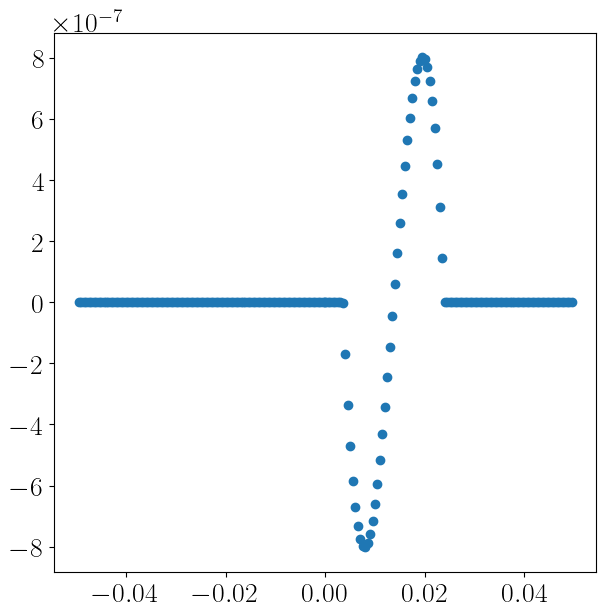

In [89]:
Imin = np.min(data[2])
Imax = np.max(data[2])
eta = np.abs(np.abs(Imin) - np.abs(Imax))/np.abs(np.abs(Imin) + np.abs(Imax))
print(eta)
plt.scatter(data[0], data[2])

In [11]:
W, A = get_matsubara_sum(T=0.2, E_typical=0.2)
print( (W/(np.pi*0.2) - 1.)/2 )

[  0.           1.           2.           3.           4.
   5.           6.           7.           8.           9.
  10.          11.00000003  12.00000611  13.0004528   14.01190669
  15.1130344   16.48916162  18.33321558  20.85569724  24.40279341
  29.63615532  37.98281736  53.16166767  88.81846559 267.78696445]


In [109]:
np.isclose(data[1], 0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

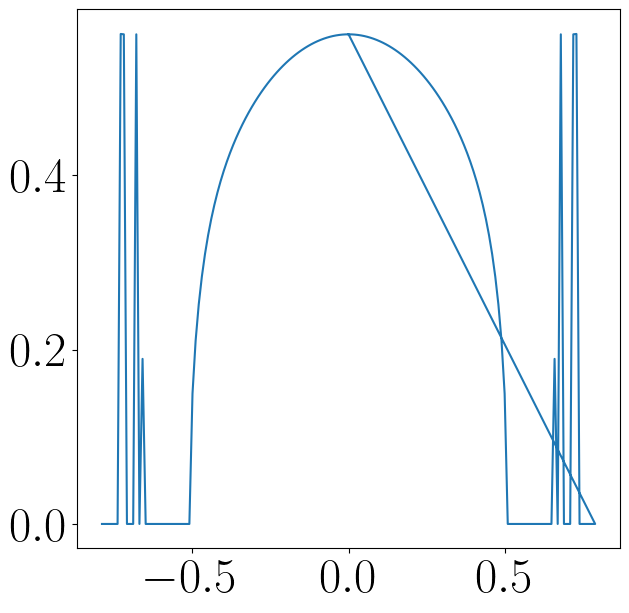

In [105]:
plt.plot(data[0], data[1])

In [11]:
tildeGamma_data = np.linspace(0, 0.1, num=100)

c = S_I_bilayer(0.1, 0.02, 0)

tc_data = []
ps_data = []

H1 = 0.
tc_array = np.array([])
ps_array = np.array([])
for Gamma in tildeGamma_data:
    tc, ps = c.Tc_theory_full(c.d_S, c.theta_I, Gamma, H1)
    tc_array = np.append(tc_array, tc)
    ps_array = np.append(ps_array, ps)
tc_data.append(tc_array)
ps_data.append(ps_array)

H1 = 0.1
tc_array = np.array([])
ps_array = np.array([])
for Gamma in tildeGamma_data:
    tc, ps = c.Tc_theory_full(c.d_S, c.theta_I, Gamma, H1)
    tc_array = np.append(tc_array, tc)
    ps_array = np.append(ps_array, ps)
tc_data.append(tc_array)
ps_data.append(ps_array)

H1 = 0.2
tc_array = np.array([])
ps_array = np.array([])
for Gamma in tildeGamma_data:
    tc, ps = c.Tc_theory_full(c.d_S, c.theta_I, Gamma, H1)
    tc_array = np.append(tc_array, tc)
    ps_array = np.append(ps_array, ps)
tc_data.append(tc_array)
ps_data.append(ps_array)



In [12]:
def M_Tim(x, t):
    W, A = get_matsubara_sum(T=t, E_typical=t)
    S = 0
    for i in range(len(W)):
        w = W[i]
        a = A[i]
        n = (w/(np.pi*t) - 1.)/2.
        S = S + 1./( (2*n+1)**2*(2*n+1+x) )
    return S

def p_an(tildeGamma, d_S, theta_I, H0, t):
    X = 4*tildeGamma/d_S
    return 8*M_Tim(X, t)*theta_I*(A_H - theta_I/2)*H0/(np.pi**2*d_S + 8*M_Tim(X, t)*theta_I**2/d_S)

def T_c_theory_1(tildeGamma, d_S, theta_I, H0):
    p0 = p_an(tildeGamma, d_S, theta_I, H0, 1.)
    X = 4*tildeGamma/d_S
    return 1. - (np.pi*p0)**2/4. - 2*M_Tim(X, 1.)*(H0*(A_H - theta_I/2) - p0*theta_I/d_S )**2

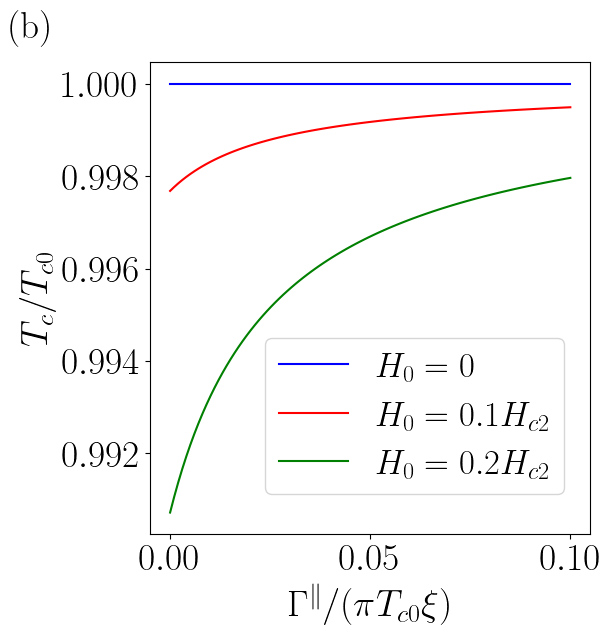

In [17]:
plt.plot(tildeGamma_data,  T_c_theory_1(tildeGamma_data, c.d_S, c.theta_I, 0.), c="blue", label=r"$H_0 = 0$")
plt.plot(tildeGamma_data,  T_c_theory_1(tildeGamma_data, c.d_S, c.theta_I, 0.1), c="red", label=r"$H_0 = 0.1 H_{c2}$")
plt.plot(tildeGamma_data,  T_c_theory_1(tildeGamma_data, c.d_S, c.theta_I, 0.2), c="green", label=r"$H_0 = 0.2 H_{c2}$")
plt.text(-0.04, 1.001, "(b)")
plt.legend(bbox_to_anchor=(0.98, 0.25), loc="right", fontsize=25)
plt.xlabel(r"$\Gamma^\parallel/(\pi T_{c0} \xi)$")
plt.ylabel(r"$T_c/T_{c0}$")

plt.tight_layout()
plt.savefig("Tc_Gamma_d_S=0-1_theta_I=0-02_b.pdf")

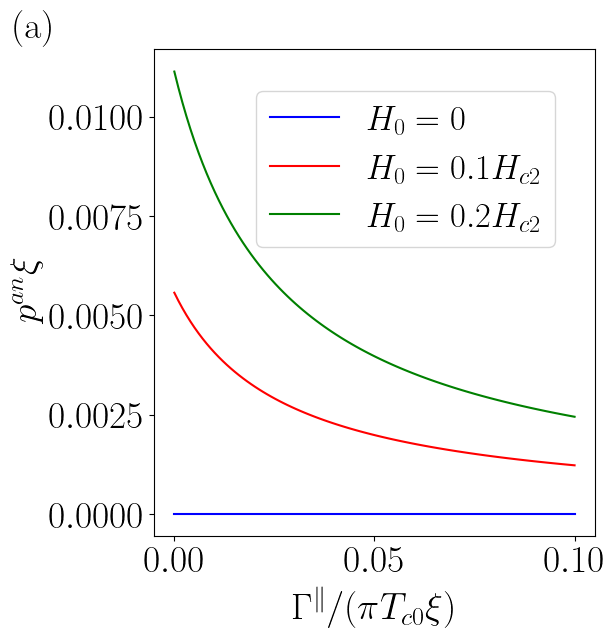

In [19]:
plt.plot(tildeGamma_data, p_an(tildeGamma_data, c.d_S, c.theta_I, 0., 1.), c="blue", label=r"$H_0 = 0$")
plt.plot(tildeGamma_data, p_an(tildeGamma_data, c.d_S, c.theta_I, 0.1, 1.), c="red", label=r"$H_0 = 0.1 H_{c2}$")
plt.plot(tildeGamma_data, p_an(tildeGamma_data, c.d_S, c.theta_I, 0.2, 1.), c="green", label=r"$H_0 = 0.2 H_{c2}$")
plt.text(-0.04, 0.012, "(a)")
plt.legend(bbox_to_anchor=(0.95, 0.95), loc="upper right", fontsize=25)
plt.xlabel(r"$\Gamma^\parallel/(\pi T_{c0} \xi)$")
plt.ylabel(r"$p^{an}\xi$")



plt.tight_layout()
plt.savefig("Tc_Gamma_d_S=0-1_theta_I=0-02_a.pdf")

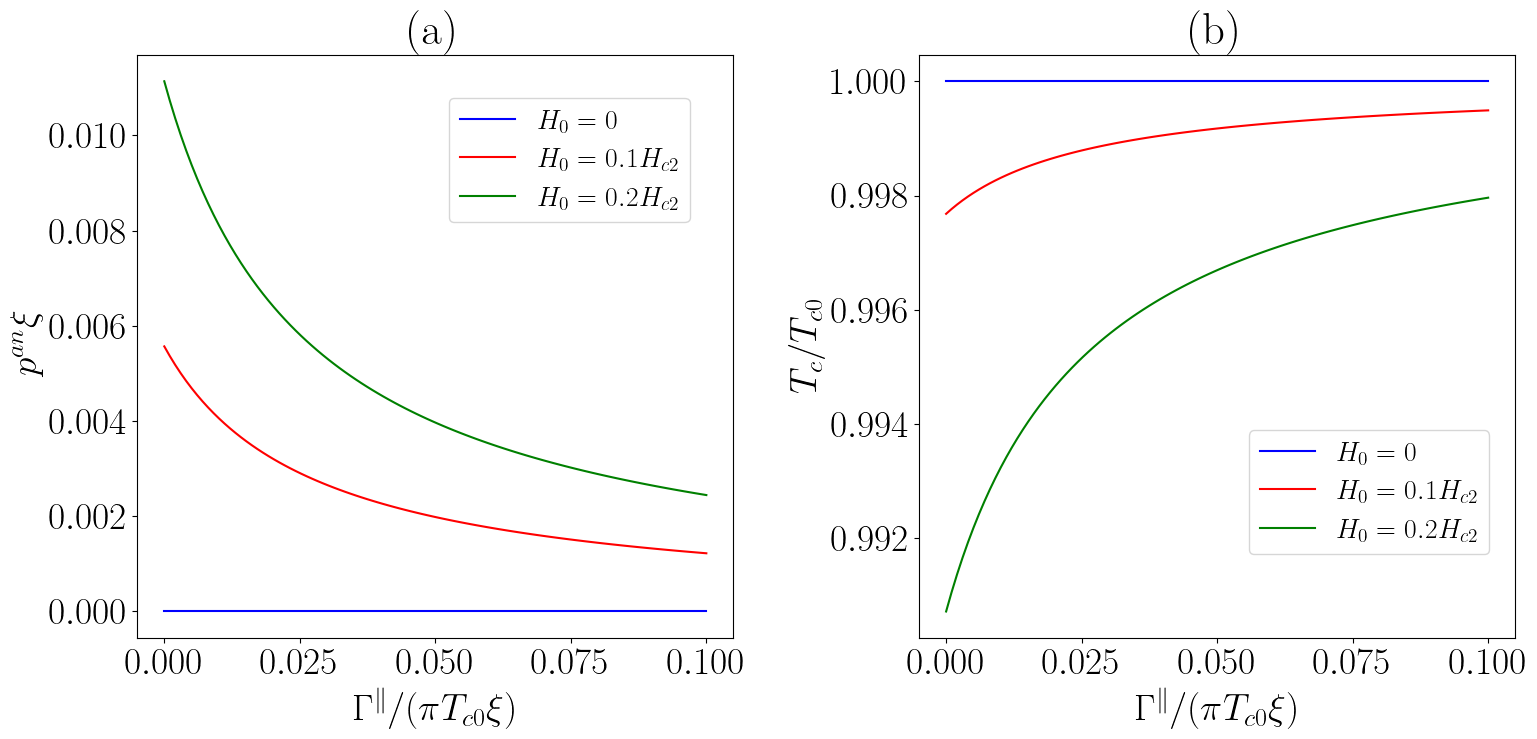

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))

axs[1].plot(tildeGamma_data,  T_c_theory_1(tildeGamma_data, c.d_S, c.theta_I, 0.), c="blue", label=r"$H_0 = 0$")
axs[1].plot(tildeGamma_data,  T_c_theory_1(tildeGamma_data, c.d_S, c.theta_I, 0.1), c="red", label=r"$H_0 = 0.1 H_{c2}$")
axs[1].plot(tildeGamma_data,  T_c_theory_1(tildeGamma_data, c.d_S, c.theta_I, 0.2), c="green", label=r"$H_0 = 0.2 H_{c2}$")
axs[1].set_title("(b)")
axs[1].legend(bbox_to_anchor=(0.98, 0.25), loc="right", fontsize=20)
axs[1].set(xlabel=r"$\Gamma^\parallel/(\pi T_{c0} \xi)$", ylabel=r"$T_c/T_{c0}$")




axs[0].plot(tildeGamma_data, p_an(tildeGamma_data, c.d_S, c.theta_I, 0., 1.), c="blue", label=r"$H_0 = 0$")
axs[0].plot(tildeGamma_data, p_an(tildeGamma_data, c.d_S, c.theta_I, 0.1, 1.), c="red", label=r"$H_0 = 0.1 H_{c2}$")
axs[0].plot(tildeGamma_data, p_an(tildeGamma_data, c.d_S, c.theta_I, 0.2, 1.), c="green", label=r"$H_0 = 0.2 H_{c2}$")
axs[0].set_title("(a)")
axs[0].legend(bbox_to_anchor=(0.95, 0.95), loc="upper right", fontsize=20)
axs[0].set(xlabel=r"$\Gamma^\parallel/(\pi T_{c0} \xi)$", ylabel=r"$p^{an} \xi$")


plt.tight_layout()
plt.savefig("Tc_Gamma_d_S=0-1_theta_I=0-02.pdf")

In [91]:
c = S_I_bilayer(0.1, 0.1, 0.)

t_array = np.linspace(0.99574, 1., num=60)

Delta_data = []
tildeW_data = []
tildeJ_data = []

def element(t, H):
    Delta, tildeW, tildeJ = c.Get_state_at_fixed_current(H, t, p_S_step=0.25*1e-3)
    return Delta, tildeW, tildeJ

import time

t0 = time.time()
H0 = 0.
results = Parallel(n_jobs=8)(delayed(element)(t, H0) for t in tqdm(t_array))
Delta_array = np.array([res[0] for res in results])
tildeW_array = np.array([res[1] for res in results])
tildeJ_array = np.array([res[2] for res in results])
Delta_data.append(Delta_array)
tildeW_data.append(tildeW_array)
tildeJ_data.append(tildeJ_array)
print(" Time used: ", time.time() - t0, "\n")

t0 = time.time()
H0 = 0.1
results = Parallel(n_jobs=8)(delayed(element)(t, H0) for t in tqdm(t_array))
Delta_array = np.array([res[0] for res in results])
tildeW_array = np.array([res[1] for res in results])
tildeJ_array = np.array([res[2] for res in results])
Delta_data.append(Delta_array)
tildeW_data.append(tildeW_array)
tildeJ_data.append(tildeJ_array)
print(" Time used: ", time.time() - t0, "\n")

t0 = time.time()
H0 = 0.15
results = Parallel(n_jobs=8)(delayed(element)(t, H0) for t in tqdm(t_array))
Delta_array = np.array([res[0] for res in results])
tildeW_array = np.array([res[1] for res in results])
tildeJ_array = np.array([res[2] for res in results])
Delta_data.append(Delta_array)
tildeW_data.append(tildeW_array)
tildeJ_data.append(tildeJ_array)
print(" Time used: ", time.time() - t0, "\n")

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [29:53<00:00, 29.89s/it]


 Time used:  2395.305192232132 



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [30:54<00:00, 30.91s/it]


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))

tc1, p_S1 = c.Tc_theory(c.d_S, c.theta_I, c.tildeGamma, 0.)
tc2, p_S2 = c.Tc_theory_full(c.d_S, c.theta_I, c.tildeGamma, 0.1)
tc3, p_S3 = c.Tc_theory_full(c.d_S, c.theta_I, c.tildeGamma, 0.15)


axs[0, 0].scatter(t_array, Delta_data[2], c="green", label=r"$H_0 = 0.15 H_{c2}$")
axs[0, 0].scatter(t_array, Delta_data[1], c="red", label=r"$H_0 = 0.1 H_{c2}$")
axs[0, 0].scatter(t_array, Delta_data[0], c="blue", label=r"$H_0 = 0$")
axs[0, 0].legend(loc="upper right")
axs[0, 0].vlines(x=[tc1, tc2, tc3], ymin=0, ymax = 0.045, 
              colors=["blue", "red", "green"], ls="--")
#axs[0, 0].set_xticks(np.linspace(t_array[2][0], t_data[0][-1], num=3))
axs[0, 0].set(xlabel=r"$T/T_{c0}$", ylabel=r"$\Delta/(\pi T_{c0})$")
axs[0, 0].set_title("(a)")


axs[0, 1].scatter(t_array, tildeW_data[2], c="green", label=r"$H_0 = 0.15 H_{c2}$")
axs[0, 1].scatter(t_array, tildeW_data[1], c="red", label=r"$H_0 = 0.1 H_{c2}$")
axs[0, 1].scatter(t_array, tildeW_data[0], c="blue", label=r"$H_0 = 0$")
#axs[0, 1].set_xticks(np.linspace(t_data[2][0], t_data[0][-1], num=3))
axs[0, 1].set(xlabel=r"$T/T_{c0}$", ylabel=r"$e W/ (\sigma_D \pi T_{c0})$")
axs[0, 1].vlines(x=[tc1, tc2, tc3], ymin=0, ymax = 0.0085, 
              colors=["blue", "red", "green"], ls="--")
#axs[0, 1].set_xticks(np.linspace(t_data[2][0], t_data[0][-1], num=3))
axs[0, 1].set_title("(b)")
axs[0, 1].legend(loc="upper right")


axs[1, 0].scatter(t_array, tildeJ_data[0], c="blue", label=r"$H_0 = 0$")
axs[1, 0].scatter(t_array, tildeJ_data[2], c="green", label=r"$H_0 = 0.15 H_{c2}$")
axs[1, 0].scatter(t_array, tildeJ_data[1], c="red", label=r"$H_0 = 0.1 H_{c2}$")
#axs[1, 0].set_xticks(np.linspace(t_data[2][0], t_data[0][-1], num=3))
axs[1, 0].set(xlabel=r"$T/T_{c0}$", ylabel=r"$ eJ_s/(\sigma_D \pi T_{c0})$")
axs[1, 0].vlines(x=[tc1, tc2, tc3], ymin=-1.*1e-5, ymax = 0.0, 
              colors=["blue", "red", "green"], ls="--")
axs[1, 0].set_title("(c)")
axs[1, 0].legend(loc="lower right")


axs[1, 1].hlines(y=[p_S1, p_S2, p_S3], xmin=t_array[0], xmax=t_array[-1], 
              colors=["blue", "red", "green"], ls="--")

t_array1 = [t_array[i] for i in range(len(t_array)) if not np.isclose(tildeW_data[0][i], 0)]
t_array2 = [t_array[i] for i in range(len(t_array)) if not np.isclose(tildeW_data[1][i], 0)]
t_array3 = [t_array[i] for i in range(len(t_array)) if not np.isclose(tildeW_data[2][i], 0)]
tildePs1 = [-tildeJ_data[0][i]/tildeW_data[0][i]/c.d_S for i in range(len(Delta_data[0])) if not np.isclose(tildeW_data[0][i], 0)]
tildePs2 = [-tildeJ_data[1][i]/tildeW_data[1][i]/c.d_S for i in range(len(Delta_data[1])) if not np.isclose(tildeW_data[1][i], 0)]
tildePs3 = [-tildeJ_data[2][i]/tildeW_data[2][i]/c.d_S for i in range(len(Delta_data[2])) if not np.isclose(tildeW_data[2][i], 0)]

axs[1, 1].scatter(t_array1, tildePs1, c="blue", label=r"$H_0 = 0$")
axs[1, 1].scatter(t_array2, tildePs2, c="red", label=r"$H_0 = 0.1 H_{c2}$")
axs[1, 1].scatter(t_array3, tildePs3, c="green", label=r"$H_0 = 0.15 H_{c2}$")
axs[1, 1].set(xlabel=r"$T/T_{c0}$", ylabel=r"$-J_s \xi/(W d_S)$")
axs[1, 1].set_title("(d)")
axs[1, 1].legend(loc="right", bbox_to_anchor=(0.999, 0.3))

plt.tight_layout()
plt.savefig("Near_Tc_thetaI=0-1_d_S=0-1.pdf", bbox_inches="tight")

In [259]:
c = S_I_bilayer(0.3, 0.1, 0)
print(c.Tc_theory(c.d_S, c.theta_I, 0.1))
print(c.Tc_theory(c.d_S, c.theta_I, 0.15))

0.9982961147267825
0.9961662581352605


In [41]:
c = S_I_bilayer(0.1, 0.3, 0.)

t_array = np.linspace(0.993, 1., num=60)

Delta_data = []
tildeW_data = []
tildeJ_data = []

def element(t, H):
    Delta, tildeW, tildeJ = c.Get_state_at_fixed_current(H, t, p_S_step=0.5*1e-3)
    return Delta, tildeW, tildeJ

import time

t0 = time.time()
H0 = 0.
results = Parallel(n_jobs=8)(delayed(element)(t, H0) for t in tqdm(t_array))
Delta_array = np.array([res[0] for res in results])
tildeW_array = np.array([res[1] for res in results])
tildeJ_array = np.array([res[2] for res in results])
Delta_data.append(Delta_array)
tildeW_data.append(tildeW_array)
tildeJ_data.append(tildeJ_array)
print(" Time used: ", time.time() - t0, "\n")

t0 = time.time()
H0 = 0.1
results = Parallel(n_jobs=8)(delayed(element)(t, H0) for t in tqdm(t_array))
Delta_array = np.array([res[0] for res in results])
tildeW_array = np.array([res[1] for res in results])
tildeJ_array = np.array([res[2] for res in results])
Delta_data.append(Delta_array)
tildeW_data.append(tildeW_array)
tildeJ_data.append(tildeJ_array)
print(" Time used: ", time.time() - t0, "\n")

t0 = time.time()
H0 = 0.15
results = Parallel(n_jobs=8)(delayed(element)(t, H0) for t in tqdm(t_array))
Delta_array = np.array([res[0] for res in results])
tildeW_array = np.array([res[1] for res in results])
tildeJ_array = np.array([res[2] for res in results])
Delta_data.append(Delta_array)
tildeW_data.append(tildeW_array)
tildeJ_data.append(tildeJ_array)
print(" Time used: ", time.time() - t0, "\n")

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [13:28<00:00, 13.48s/it]


 Time used:  1136.248874425888 



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [15:38<00:00, 15.65s/it]


 Time used:  1232.354453086853 



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [15:22<00:00, 15.37s/it]


 Time used:  1194.0419545173645 



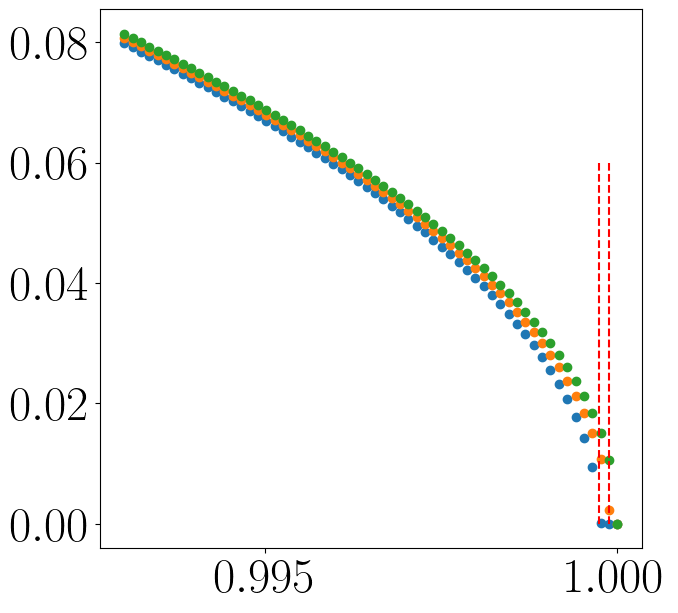

In [42]:
plt.scatter(t_array, Delta_data[2])
plt.scatter(t_array, Delta_data[1])
plt.scatter(t_array, Delta_data[0])



H1 = 0.1
Qm0 =  7*zeta(3)*c.theta_I*(A_H - c.theta_I/2)*H1/(c.d_S*(np.pi**2 + 7*zeta(3)*c.theta_I**2/c.d_S**2))

H1 = 0.15
Qm1 =  7*zeta(3)*c.theta_I*(A_H - c.theta_I/2)*H1/(c.d_S*(np.pi**2 + 7*zeta(3)*c.theta_I**2/c.d_S**2))

tc11 = 1 - (np.pi**2*Qm0**2/4  + 7*zeta(3)*(A_H*H1 - c.theta_I*H1/2 - c.theta_I*Qm0/c.d_S)**2/4)

plt.vlines([c.Tc_theory_full(c.d_S, c.theta_I, 0.1, Qm0), 
            c.Tc_theory_full(c.d_S, c.theta_I, 0.15, Qm1)], ymin=0., ymax=0.06, linestyle="--", color="red")

C:\Users\up_d_quark\AppData\Local\Temp\ipykernel_11608\2485715638.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(t_array, -tildeJ_data[2]/tildeW_data[2]/c.d_S)


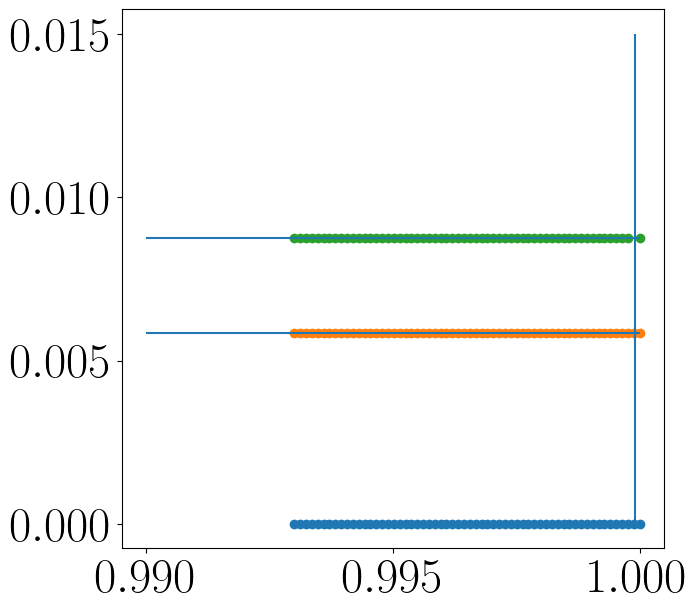

In [45]:
plt.scatter(t_array, -tildeJ_data[0]/tildeW_data[0]/c.d_S)
plt.scatter(t_array, -tildeJ_data[1]/tildeW_data[1]/c.d_S)

plt.scatter(t_array, -tildeJ_data[2]/tildeW_data[2]/c.d_S)


plt.hlines([Qm0, Qm1], xmin=0.99, xmax=1)
plt.vlines(c.Tc_theory(c.d_S, c.theta_I, 0.1), ymin=0, ymax=0.015)

 tc =  [ 0.99990498 -2.32891628]  tc0 =  0.9998845428585611
[[2.27246332e-13 8.72626772e-11]
 [8.72626772e-11 3.37859253e-08]]


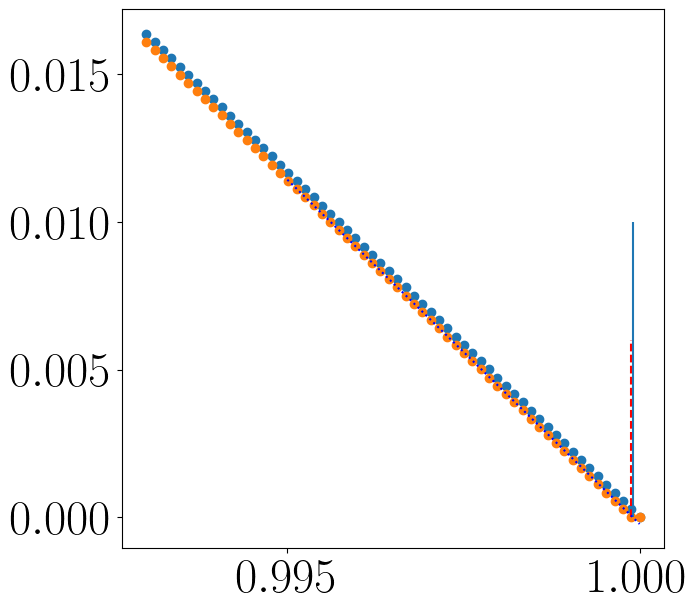

In [47]:
plt.scatter(t_array, tildeW_data[0])
plt.scatter(t_array, tildeW_data[1])



H1 = 0.1
Qm0 = 7*zeta(3)*c.theta_I*(A_H - c.theta_I/2)*H1/(c.d_S*(np.pi**2 + 7*zeta(3)*c.theta_I**2/c.d_S**2))


tc11 =  c.Tc_theory_full(c.d_S, c.theta_I, 0.1, Qm0, 0)

plt.vlines([c.Tc_theory_full(c.d_S, c.theta_I, 0.1, Qm0)], ymin=0., ymax=0.006, linestyle="--", color="red")


def foo(t, tc, a):
    #return 3.06*tc*a*np.sqrt(np.abs(1. - t/tc))/np.pi
    return  a*(t-tc)
    #return np.heaviside(1. - t/tc, 1)*a*tc*np.sqrt(np.abs(1. - t/tc))
    
popt, pcov = curve_fit(foo, t_array[0:16],  tildeW_data[1][0:16])
print(" tc = ", popt, " tc0 = ", tc11)
print(pcov)

plt.vlines([ c.Tc_theory(c.d_S, c.theta_I, 0.1)], ymin=0, ymax=0.01)

plt.plot(np.linspace(0.995,1), foo(np.linspace(0.995,1), *popt), c="blue", linestyle=":")

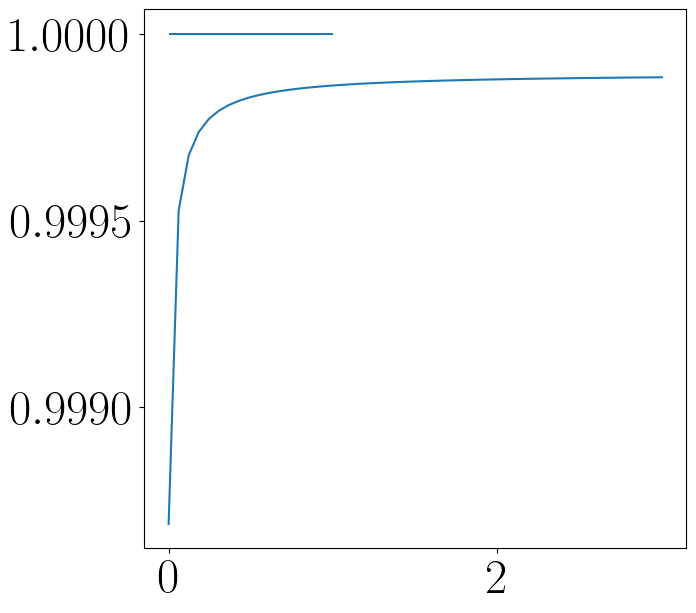

In [115]:
c = S_I_bilayer(0.1, 0.1, 0.)

Gammas = np.linspace(0, 3)
tc = np.array([])
for Gamma in Gammas:
    t1 = c.Tc_theory_full(c.d_S, c.theta_I, Gamma, 0.1, Qm0)
    tc = np.append(tc, t1)
plt.plot(Gammas, tc)
plt.hlines(1, xmin=0, xmax=1)

In [297]:


t_array = np.linspace(0.998, 1., num=60)

Delta_data = []
tildeW_data = []
tildeJ_data = []

def element(a, t, H):
    Delta, tildeW, tildeJ = a.Get_state_at_fixed_current(H, t, p_S_step=0.5*1e-3)
    return Delta, tildeW, tildeJ

import time

t0 = time.time()
H0 = 0.1
c1 = S_I_bilayer(0.1, 0.1, 0.)
results = Parallel(n_jobs=8)(delayed(element)(c1, t, H0) for t in tqdm(t_array))
Delta_array = np.array([res[0] for res in results])
tildeW_array = np.array([res[1] for res in results])
tildeJ_array = np.array([res[2] for res in results])
Delta_data.append(Delta_array)
tildeW_data.append(tildeW_array)
tildeJ_data.append(tildeJ_array)
print(" Time used: ", time.time() - t0, "\n")

t0 = time.time()
H0 = 0.1
c2 = S_I_bilayer(0.1, 0.1, 0.05)
results = Parallel(n_jobs=8)(delayed(element)(c2, t, H0) for t in tqdm(t_array))
Delta_array = np.array([res[0] for res in results])
tildeW_array = np.array([res[1] for res in results])
tildeJ_array = np.array([res[2] for res in results])
Delta_data.append(Delta_array)
tildeW_data.append(tildeW_array)
tildeJ_data.append(tildeJ_array)
print(" Time used: ", time.time() - t0, "\n")

t0 = time.time()
H0 = 0.1
c3 = S_I_bilayer(0.1, 0.1, 0.5)
results = Parallel(n_jobs=8)(delayed(element)(c3, t, H0) for t in tqdm(t_array))
Delta_array = np.array([res[0] for res in results])
tildeW_array = np.array([res[1] for res in results])
tildeJ_array = np.array([res[2] for res in results])
Delta_data.append(Delta_array)
tildeW_data.append(tildeW_array)
tildeJ_data.append(tildeJ_array)
print(" Time used: ", time.time() - t0, "\n")

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [15:26<00:00, 15.44s/it]


 Time used:  1215.0278561115265 



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [17:11<00:00, 17.20s/it]


 Time used:  1302.3627331256866 



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [14:21<00:00, 14.37s/it]


 Time used:  1144.150972366333 



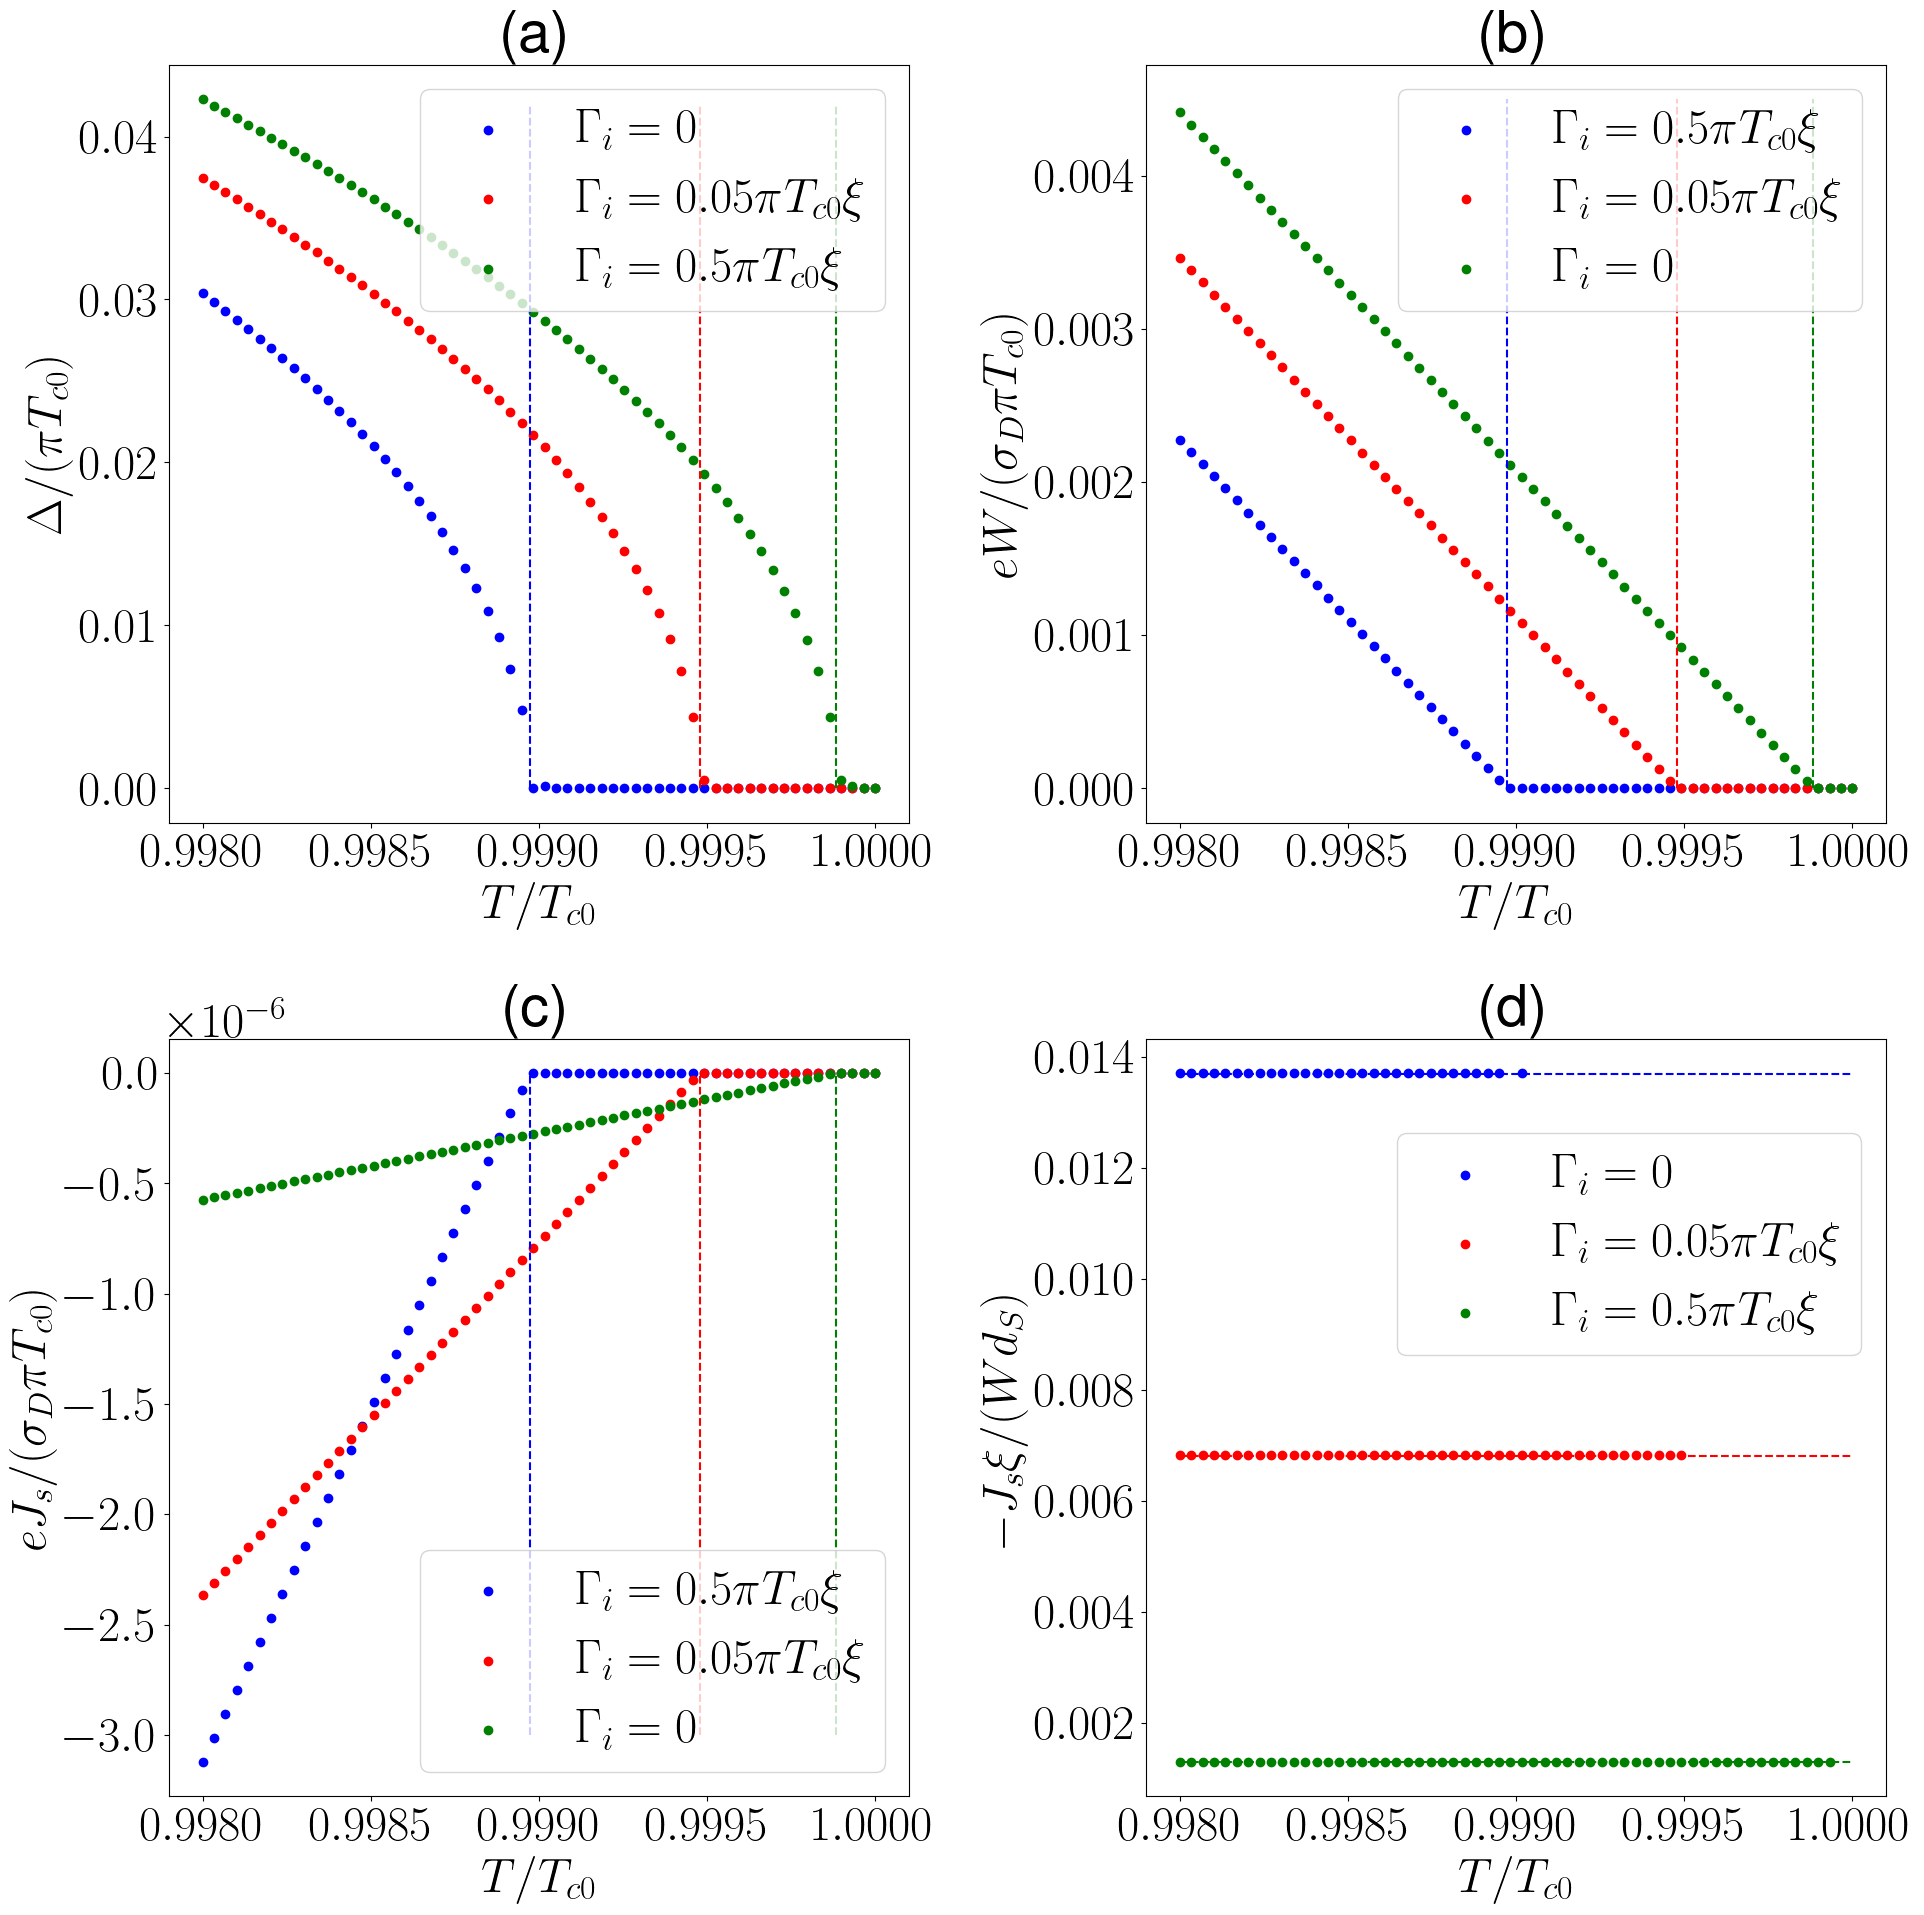

In [355]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))

c1 = S_I_bilayer(0.1, 0.1, 0.)
c2 = S_I_bilayer(0.1, 0.1, 0.05)
c3 = S_I_bilayer(0.1, 0.1, 0.5)

tc1, p_S1 = c1.Tc_theory(c1.d_S, c1.theta_I, c1.tildeGamma, 0.1)
tc2, p_S2 = c2.Tc_theory_full(c2.d_S, c2.theta_I, c2.tildeGamma, 0.1)
tc3, p_S3 = c3.Tc_theory_full(c3.d_S, c3.theta_I, c3.tildeGamma, 0.1)

axs[0, 0].scatter(t_array, Delta_data[0], c="blue", label=r"$\Gamma_i = 0$")
axs[0, 0].scatter(t_array, Delta_data[1], c="red", label=r"$\Gamma_i = 0.05\pi T_{c0} \xi$")
axs[0, 0].scatter(t_array, Delta_data[2], c="green", label=r"$\Gamma_i = 0.5\pi T_{c0} \xi $")
axs[0, 0].legend(loc="upper right")
axs[0, 0].vlines(x=[tc1, tc2, tc3], ymin=0, ymax = 0.042, 
              colors=["blue", "red", "green"], ls="--")
#axs[0, 0].set_xticks(np.linspace(t_array[2][0], t_data[0][-1], num=3))
axs[0, 0].set(xlabel=r"$T/T_{c0}$", ylabel=r"$\Delta/(\pi T_{c0})$")
axs[0, 0].set_title("(a)")


axs[0, 1].scatter(t_array, tildeW_data[0], c="blue", label=r"$\Gamma_i = 0.5\pi T_{c0} \xi$")
axs[0, 1].scatter(t_array, tildeW_data[1], c="red", label=r"$\Gamma_i = 0.05\pi T_{c0} \xi$")
axs[0, 1].scatter(t_array, tildeW_data[2], c="green", label=r"$\Gamma_i = 0$")


#axs[0, 1].set_xticks(np.linspace(t_data[2][0], t_data[0][-1], num=3))
axs[0, 1].set(xlabel=r"$T/T_{c0}$", ylabel=r"$e W/ (\sigma_D \pi T_{c0})$")
axs[0, 1].vlines(x=[tc1, tc2, tc3], ymin=0, ymax = 0.0045, 
              colors=["blue", "red", "green"], ls="--")
#axs[0, 1].set_xticks(np.linspace(t_data[2][0], t_data[0][-1], num=3))
axs[0, 1].set_title("(b)")
axs[0, 1].legend(loc="upper right")


axs[1, 0].scatter(t_array, tildeJ_data[0], c="blue", label=r"$\Gamma_i = 0.5\pi T_{c0} \xi$")
axs[1, 0].scatter(t_array, tildeJ_data[1], c="red", label=r"$\Gamma_i = 0.05\pi T_{c0} \xi$")
axs[1, 0].scatter(t_array, tildeJ_data[2], c="green", label=r"$\Gamma_i = 0$")
#axs[1, 0].set_xticks(np.linspace(t_data[2][0], t_data[0][-1], num=3))
axs[1, 0].set(xlabel=r"$T/T_{c0}$", ylabel=r"$ eJ_s/(\sigma_D \pi T_{c0})$")
axs[1, 0].vlines(x=[tc1, tc2, tc3], ymin=-0.3*1e-5, ymax = 0.0, 
              colors=["blue", "red", "green"], ls="--")
axs[1, 0].set_title("(c)")
axs[1, 0].legend(loc="lower right")



axs[1, 1].hlines(y=[p_S1, p_S2, p_S3], xmin=t_array[0], xmax=t_array[-1], 
              colors=["blue", "red", "green"], ls="--")

t_array1 = [t_array[i] for i in range(len(t_array)) if not np.isclose(tildeW_data[0][i], 0)]
t_array2 = [t_array[i] for i in range(len(t_array)) if not np.isclose(tildeW_data[1][i], 0)]
t_array3 = [t_array[i] for i in range(len(t_array)) if not np.isclose(tildeW_data[2][i], 0)]
tildePs1 = [-tildeJ_data[0][i]/tildeW_data[0][i]/c.d_S for i in range(len(Delta_data[0])) if not np.isclose(tildeW_data[0][i], 0)]
tildePs2 = [-tildeJ_data[1][i]/tildeW_data[1][i]/c.d_S for i in range(len(Delta_data[1])) if not np.isclose(tildeW_data[1][i], 0)]
tildePs3 = [-tildeJ_data[2][i]/tildeW_data[2][i]/c.d_S for i in range(len(Delta_data[2])) if not np.isclose(tildeW_data[2][i], 0)]

axs[1, 1].scatter(t_array1, tildePs1, c="blue", label=r"$\Gamma_i = 0$")
axs[1, 1].scatter(t_array2, tildePs2, c="red", label=r"$\Gamma_i = 0.05\pi T_{c0} \xi$")
axs[1, 1].scatter(t_array3, tildePs3, c="green", label=r"$\Gamma_i = 0.5\pi T_{c0} \xi$")
axs[1, 1].set(xlabel=r"$T/T_{c0}$", ylabel=r"$-J_s \xi/(W d_S)$")
axs[1, 1].set_title("(d)")
axs[1, 1].legend(loc="lower right", bbox_to_anchor=(0.999, 0.55))

plt.tight_layout()
plt.savefig("Near_Tc_thetaI=0-1_d_S=0-1_Gamma_effect.pdf", bbox_inches="tight")

In [307]:
pS_0m, pS_1m, pS_2m

(np.float64(0.013703883101490063),
 np.float64(-0.1136446421338226),
 np.float64(-0.1136446421338226))

In [289]:
c1.Tc_theory_full(c1.d_S, c1.theta_I, 0.5, 0.1)

np.float64(0.9998838587906922)

In [295]:
c1.Tc_theory_full(c1.d_S, c1.theta_I, 0.05, 0.1)

np.float64(0.9994778025193854)

In [285]:
c1.Tc_theory_full(c1.d_S, c1.theta_I, 0.00, 0.1)

np.float64(0.9989714989623663)

In [193]:
c = S_I_bilayer(c3.d_S, c3.theta_I, c3.tildeGamma)
c.Tc_theory_full(c.d_S, c.theta_I, c.tildeGamma, H0=0.1)

array(0.99917754)

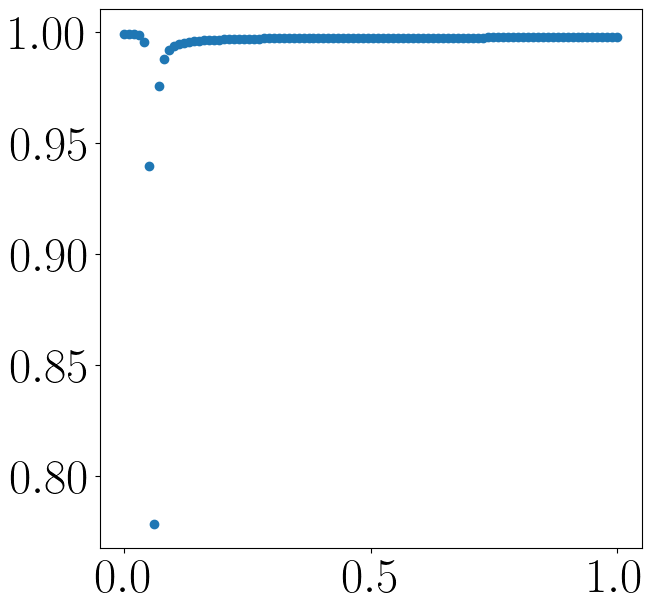

In [231]:
c = S_I_bilayer(0.1, 0.1, 0.)

dd = np.linspace(0, 01., num=100)
ddd = [c.Tc_theory_full(0.1, 0.1, dd[i], 0.1) for i in range(len(dd))]
plt.scatter(dd, ddd)